In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt

In [2]:
EXECUTABLES_DIR = '../bin'
ALGORITHM_FILENAME = 'cvrp_cws'
INSTANCE_FILENAME = 'B-n31-k5'#'A-n33-k5'
INSTANCE_FILEPATH = 'instancias/%s.txt' % INSTANCE_FILENAME


In [3]:
def ruta_instancia(instancia):
    return 'instancias/%s.txt' % instancia

# Creo el archivo levantando los parámetros de la instancia que me son relevantes
def crear_instancia(instancia):
    file_name = 'instancias/corridas/%s.txt' % (instancia)
    output_file = open(file_name, 'w')
    
    input_file = open(ruta_instancia(instancia), 'r')
    
    lines = input_file.readlines()
    # number of vertex in graph
    v_size = int(lines[3].split()[2])
    output_file.write(str(v_size)+ '\n')
    # capacity of each truck
    output_file.write(lines[5].split()[2] + '\n')
    # cordenates of vertex in euclidean space
    for index in range(7, 7+v_size):
        output_file.write(lines[index])
    # objective capacity of vertex
    for index in range(7+v_size+1, 7+v_size+1+v_size):
        output_file.write(lines[index])

    input_file.close()
    output_file.close()
    return file_name

In [4]:
# Creo un DataFrame con la instancia pedida
def cargar_informacion(nombre_instancia):
    matrix_data = []
    archivo_instancia = open(nombre_instancia, 'rb')
    
    lines = archivo_instancia.readlines()
    # number of vertex in graph
    v_size = int(lines[0])
    # camiones
    truck_size = int(lines[1])
    # cordenates of vertex in euclidean space
    for index in range(2, 2+v_size):
        line = lines[index].split()
        matrix_data.append( [int(line[0]), int(line[1]) ,int(line[2]) ,0, truck_size, v_size])
    # objective capacity of vertex
    for index in range(2+v_size, 2+v_size+v_size):
        line = lines[index].split()
        vertex = int(line[0])
        objective = int(line[1])
        matrix_data[vertex-1][3] = objective
        
    archivo_instancia.close()
    return pd.DataFrame(matrix_data, columns=['numero_punto','x', 'y','objetivo','truck_amount','vertex_amount'])

In [5]:
# Corro el $algoritmo (ejecutable) para el input del $archivo
def correr_instancia(dataframe, algoritmo,file_name):
    input_data = str(dataframe.loc[dataframe.numero_punto == 1, 'vertex_amount'].values[0]) + '\n' 
    input_data = input_data + str(dataframe.loc[dataframe.numero_punto == 1, 'truck_amount'].values[0]) + '\n' 
    input_data = input_data + dataframe[['x', 'y','objetivo']].to_csv(header=False,index=False,sep=' ',line_terminator='\n')
    
    output_file = open(file_name, 'w')
    output_file.write(input_data)
    output_file.close()
    
    try:
        result = subprocess.run(["{0}/{1}".format(EXECUTABLES_DIR, algoritmo)], stdout=subprocess.PIPE, input=str.encode(input_data))
    except subprocess.CalledProcessError as e:
        Raise ("Algorithm ERROR {}".format(e.output))
    results = result.stdout.decode("utf-8").split('\n')
    results.pop(len(results) -1)
    return results

def lista_de(lista,tipo):
    return list(map(lambda valor : tipo(valor),lista))

In [6]:
def parsear_y_guardar(dataframe, listas):
    camiones = int(listas[0])
    dataframe['result'] = int(listas[camiones+1])
    dataframe['caminos'] = 0
   
    # Elijo un cluster para cada camimno
    indice_grupo = 1
    for index in range(camiones):
        caminos = map(lambda x : int(x), listas[indice_grupo].split())
        for parada in caminos:
            dataframe.loc[dataframe.numero_punto == parada, 'caminos'] = indice_grupo
        indice_grupo = indice_grupo + 1
          
#     El primero está en todos los caminos así que mejor lo saco de todos.
    dataframe.loc[dataframe.numero_punto == 1, 'caminos'] = 0
    
    
    return dataframe
    

In [7]:
# Englobo todas las funciones y devuelvo un DataFrame con la instancia y los clusters calculados
def calcular_y_graficar(instancia, ejecutable):
    file_name = crear_instancia(instancia)
    dataframe = cargar_informacion(file_name)
    results = correr_instancia(dataframe, ejecutable, file_name)
    dataframe = parsear_y_guardar(dataframe, results)
    return dataframe, results

## Correr una instancia con parámetros

In [8]:
dataframe, results = calcular_y_graficar(INSTANCE_FILENAME, ALGORITHM_FILENAME)
dataframe

,numero_punto,x,y,objetivo,truck_amount,vertex_amount,result,caminos
0,1,17,76,0,100,31,702,0
1,2,24,6,25,100,31,702,5
2,3,96,29,3,100,31,702,4
3,4,14,19,13,100,31,702,5
4,5,14,32,17,100,31,702,4
5,6,0,34,16,100,31,702,1
6,7,16,22,9,100,31,702,2
7,8,20,26,22,100,31,702,3
8,9,22,28,10,100,31,702,3
9,10,17,23,16,100,31,702,2


## Graficar la instancia anterior

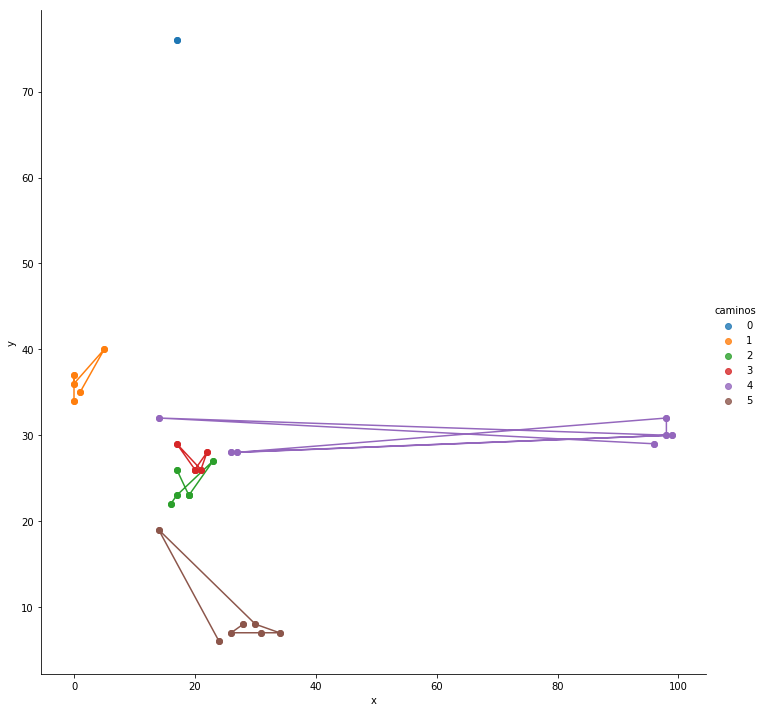

In [9]:
sns.lmplot(data=dataframe,x='x',y='y',hue='caminos',fit_reg=False, legend=True, legend_out=True,height=10)
for key,grp in dataframe.groupby('caminos'):
    plt.plot(grp.x,grp.y,'o-',label = key)


In [10]:
results

['5',
 '1 17 19 6 26 22 1',
 '1 23 7 10 14 18 13 1',
 '1 9 24 8 31 30 1',
 '1 21 11 28 3 27 29 5 1',
 '1 15 16 12 25 20 2 4 1',
 '702']

In [11]:
# results = ['5', '1 15 17 9 3 16 29 1', '1 12 5 26 7 8 13 32 2 1', '1 20 4 27 25 30 10 1', '1 23 28 18 22 1', '1 24 6 19 14 21 1 31 11 1', '661']
# results

In [12]:
import networkx as nx

def graficarSolucion(dataframe, results):
    G = nx.Graph()
    node_sizes = []
    for index, row in dataframe.iterrows():
        G.add_node(row["numero_punto"],pos=(row["x"],row["y"]), color=row["caminos"])
        node_sizes.append(100)

    node_sizes[0] = 700 # hago mas grande el depot (que es el primero)

    c = int(results[0])
    for i in range(c):
        camino = results[i+1]
        camino = camino.split()
        for j in range(1,len(camino)):
            G.add_edge(int(camino[j-1]), int(camino[j]), color=i)

    pos=nx.get_node_attributes(G,'pos')

    edges = G.edges()
    nodes = G.nodes()
    edge_colors = [G[u][v]['color'] for u,v in edges]

    node_colors = []
    for i in range(len(G)):
        node_colors.append(G.nodes[(i+1)]['color'])


    plt.figure(1,figsize=(12,12)) 
    nx.draw(G,pos, edge_color=edge_colors, node_size=node_sizes, node_color=node_colors)
    plt.show()

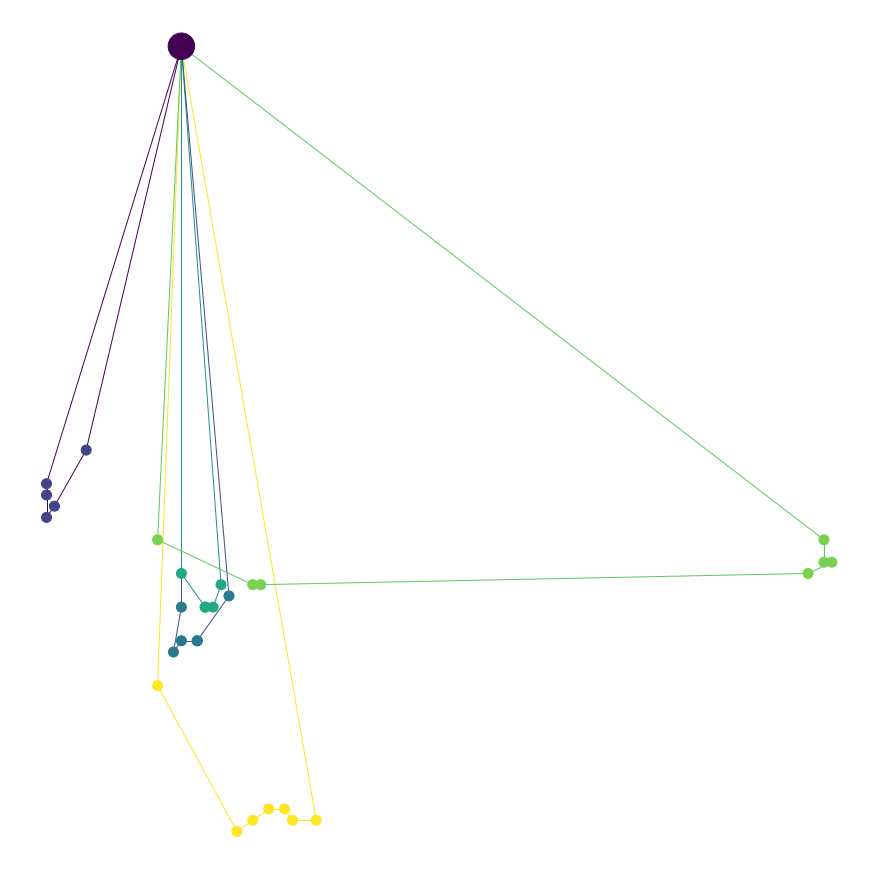

In [13]:
graficarSolucion(dataframe, results)

# Comparación de heurísticas

In [21]:
import time

0.11476373672485352
0.08124613761901855


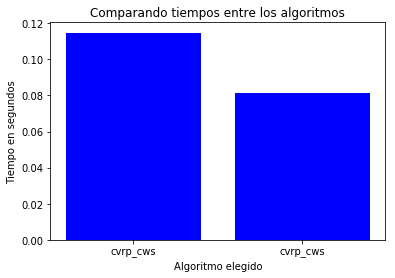

In [34]:
def graficar_tiempos(instancia, algoritmos):
    x = []
    times = []
    for algoritmo in algoritmos:
        x.append(algoritmo)
        start = time.time()
        dataframe, results = calcular_y_graficar(instancia, algoritmo)
        end = time.time()
        print(end-start)
        times.append(end-start)
        
    x_pos = [i for i, _ in enumerate(x)]
    plt.bar(x_pos, times, color='blue')
    plt.xlabel("Algoritmo elegido")
    plt.ylabel("Tiempo en segundos")
    plt.title("Comparando tiempos entre los algoritmos")

    plt.xticks(x_pos, x)

    plt.show()
    
graficar_tiempos('A-n33-k5', ['cvrp_cws', 'cvrp_cws'])    

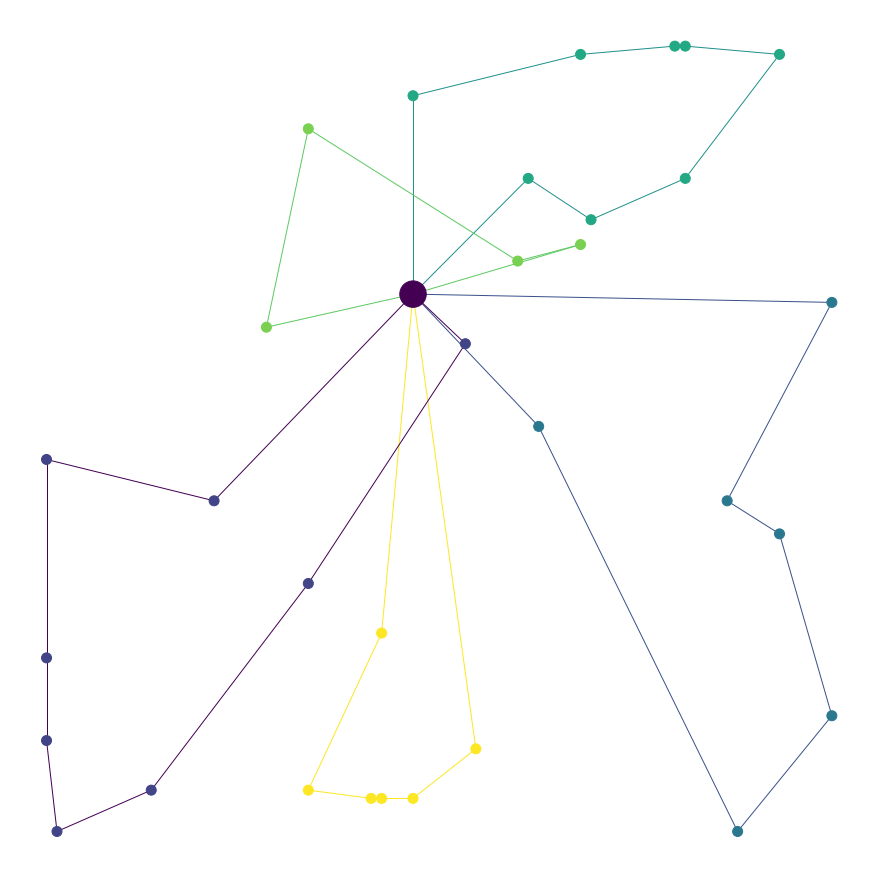

In [33]:
instancia = 'A-n33-k5'
dataframe, results = calcular_y_graficar(instancia, 'cvrp_cws')
graficarSolucion(dataframe, results)

In [18]:
dataframe, results = calcular_y_graficar('A-n33-k5', 'cvrp_greedy')

In [19]:
graficarSolucion(dataframe, results)

KeyError: 34